## Project 5: Interpretability
* **Background**: Interpretable ML refers to methods and models that make the behavior and predictions of ML systems understandable to humans. The higher the interpretability, the easier it is for someone to understand why certain decisions or predictions were made by our model. In some cases, knowing why your model predicted the way it did can help you learn more about the problem, the data and in which scenarios your model may fail.
* **Problem statement**: The focus of this project is to design, implement, test, compare, and document a selection of model interpretability methods in order to reason about why our models make the decisions they do with applications to, e.g. regression or classification problems. The algorithms must be optimized with regard to applicable properties of explanation methods (see IML Sec. 2.5), i.e. results must be shown such that end-users readily can see an explanation for a prediction. To quantify the quality of the methods, comparative evaluations should be carried out via objective metrics and the algorithms should be assessed against state of the art.
* **Technologies (inspiration)**:
    * scikit-learn, Machine Learning in Python. [Link](https://scikit-learn.org/stable/)
    * C. Davidson-Pilon, "lifelines: survival analysis in Python", Journal of Open Source Software, Vol. 4, No. 40, 2019. [Link](https://doi.org/10.21105/joss.01317)
    * S. Pölsterl, "scikit-survival: A Library for Time-to-Event Analysis Built on Top of scikit-learn," Journal of Machine Learning Research, vol. 21, no. 212, 2020. [Link](https://www.jmlr.org/papers/volume21/20-729/20-729.pdf)
    * M. Abadi et al., "Tensorflow: A system for large-scale machine learning", 12th USENIX Symposium on Operating Systems Design and Implementation (OSDI 16), pp. 265–283, 2016. [Link](https://www.tensorflow.org/)
* **Data-sets (inspiration)**:
    * P. Perera, "The Boston Housing Dataset", regression, 2018. [Link](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset)
    * P. Campanelli, "League of Legends Ranked Matches", classification, 2017. [Link](https://www.kaggle.com/datasets/paololol/league-of-legends-ranked-matches)
    * C. Lillelund, "CS:GO Round Winner Classification", classification, 2020. [Link](https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification)
    * S. Lundberg, "ImageNet50", classification, 2018. [Link](https://shap.readthedocs.io/en/latest/generated/shap.datasets.imagenet50.html)
    * S. Lundberg, "NHANES", survival analysis, 2018. [Link](https://shap.readthedocs.io/en/latest/generated/shap.datasets.nhanesi.html)
* **References (inspiration)**:
    * S. Lundberg and S. Lee, "A Unified Approach to Interpreting Model Predictions", Conf. on Neural Information Processing Systems, 2017. [Link](https://shap.readthedocs.io/en/latest/)
    * M. Ribeiro, S. Singh and C. Guestrin. "Why should I trust you?: Explaining the predictions of any classifier", Conf. on Knowledge Discovery and Data Mining, 2016. [Link](https://arxiv.org/abs/1602.04938)

In [32]:
import numpy as np
import shap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.tree import _tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from six import StringIO  
from scipy.special import softmax


import lightgbm as lgb



plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
%matplotlib inline

In [33]:
""" Create the dataset """
df = pd.read_csv('csgo_round_snapshots.csv')
display(df.head())
display(df.describe())

print(f"Number of samples: {df.shape[0]}")

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


Number of samples: 122410


In [34]:
# Split the data into target and features
y = df['round_winner'] # categorical target
X = df.drop(['round_winner'], axis=1)

In [35]:
# print the shape of the DataFrame
print('DataFrame shape:', X.shape)

# print the column names of the DataFrame
print('Column names:', X.columns)

DataFrame shape: (122410, 96)
Column names: Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',

In [36]:

objects = ['map', 'bomb_planted']

# Using LabelEncoder to encode the categorical variables
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Using OneHotEncoder to encode the categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(ohe.fit_transform(X[['map', 'bomb_planted']]))
X_encoded.columns = ohe.get_feature_names_out(['map', 'bomb_planted'])
X_encoded.index = X.index

# Concatenate the encoded variables with the original dataset
numerical_X = X.drop(['map', 'bomb_planted'], axis=1)
X = pd.concat([numerical_X, X_encoded], axis=1)



In [38]:
# Display which

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [7]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, 
                  d_train, 
                  100000, 
                  valid_sets=[d_test], 
                  early_stopping_rounds=50, 
                  verbose_eval=1000)



'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's binary_logloss: 0.41246
[2000]	valid_0's binary_logloss: 0.394186
[3000]	valid_0's binary_logloss: 0.380777
[4000]	valid_0's binary_logloss: 0.369721
[5000]	valid_0's binary_logloss: 0.360272
[6000]	valid_0's binary_logloss: 0.352709
[7000]	valid_0's binary_logloss: 0.345094
[8000]	valid_0's binary_logloss: 0.337789
[9000]	valid_0's binary_logloss: 0.331821
[10000]	valid_0's binary_logloss: 0.327089
[11000]	valid_0's binary_logloss: 0.322228
[12000]	valid_0's binary_logloss: 0.317559
[13000]	valid_0's binary_logloss: 0.312858
[14000]	valid_0's binary_logloss: 0.308895
[15000]	valid_0's binary_logloss: 0.305136
[16000]	valid_0's binary_logloss: 0.301674
[17000]	valid_0's binary_logloss: 0.298104
[18000]	valid_0's binary_logloss: 0.295361
Early stopping, best iteration is:
[18469]	valid_0's binary_logloss: 0.294222


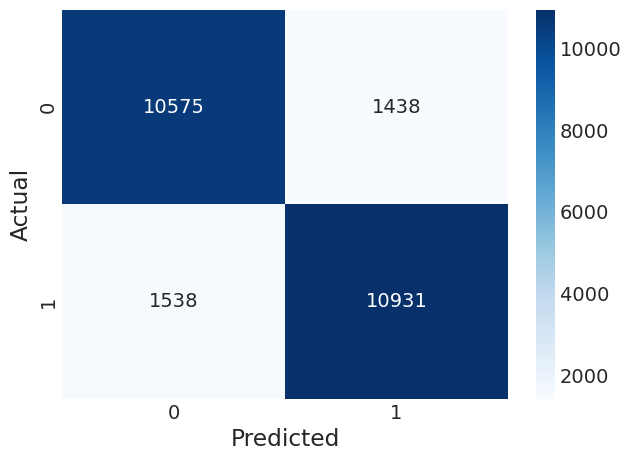

Accuracy: 0.8784413038150478
Recall: 0.87665410217339
Precision: 0.883741612094753


In [8]:
# Create confusion matrix
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Create confusion matrix
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Calculate the precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")



In [9]:

# Show prediction for index n of the test set
for n in range(0, 10):
    print(f"Prediction: {model.predict(X_test.iloc[n:n+1])} with label {y_test[n]}")


Prediction: [0.55719569] with label 1
Prediction: [0.99959202] with label 1
Prediction: [3.02225389e-05] with label 0
Prediction: [0.28202043] with label 0
Prediction: [0.98532067] with label 1
Prediction: [0.00033865] with label 0
Prediction: [0.01587297] with label 0
Prediction: [0.04799788] with label 0
Prediction: [0.89638473] with label 1
Prediction: [0.05830713] with label 0


## Explainability methods

In [10]:

# Initialize necessary JavaScript code to render SHAP plots in the notebook 
shap.initjs()

In [11]:

explainer = shap.TreeExplainer(model)

# Load shap_values from file if it exists
try:
    shap_values = np.load('shap_values.npy')
    print('Loaded shap_values from file')
except:
    # Create the explainer
    shap_values = explainer.shap_values(X)
    np.save('shap_values.npy', shap_values)
    print('Could not load shap_values from file')


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Could not load shap_values from file



# A more complete picture using partial dependence plots
To understand a feature’s importance in a model it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values. To visualize this for a linear model we can build a classical partial dependence plot and show the distribution of feature values as a histogram on the x-axis:

In [15]:
# Sampling 100 instances to reduce the computational cost
num_samples = 100
X100 = shap.utils.sample(X, num_samples) 

Index(['ct_armor', 't_armor', 'ct_money', 't_money', 't_helmets', 'time_left',
       't_score', 'ct_score', 't_health', 'ct_health', 'ct_defuse_kits',
       't_players_alive', 'ct_helmets', 'bomb_planted_False', 'ct_weapon_usps',
       't_weapon_glock', 'ct_weapon_m4a4', 't_weapon_ak47', 't_weapon_sg553',
       'ct_weapon_awp'],
      dtype='object')


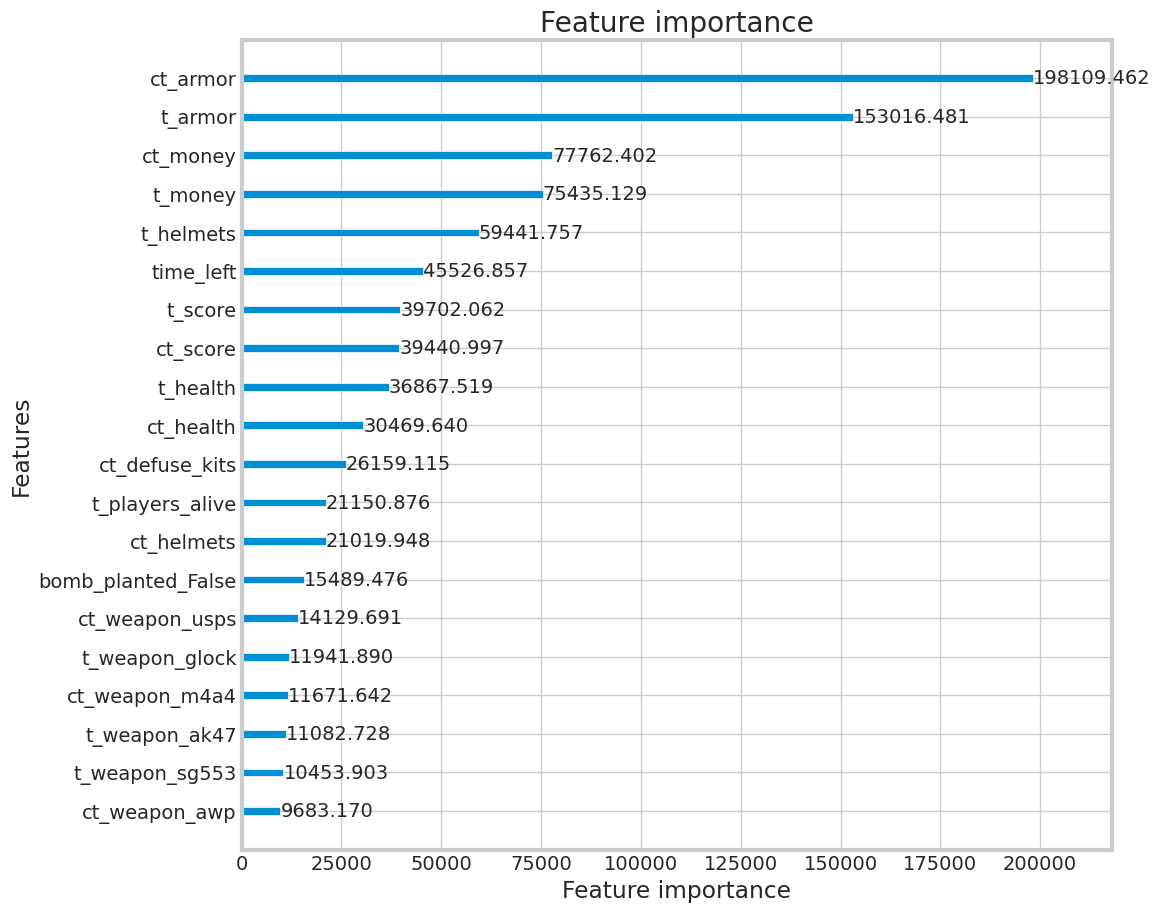

In [24]:
# Show the feature importance
lgb.plot_importance(model, figsize=(10, 10), importance_type='gain', max_num_features=20)

# Create a list of the top 20 features
top_features = X.columns[list(model.feature_importance(importance_type='gain').argsort()[-20:][::-1])]
print(top_features)

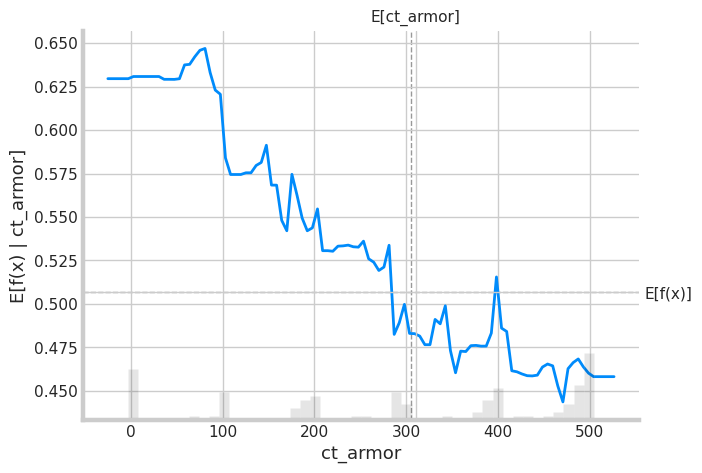

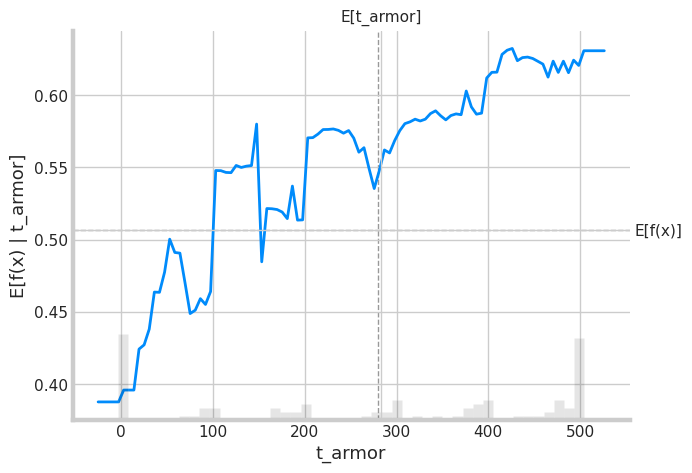

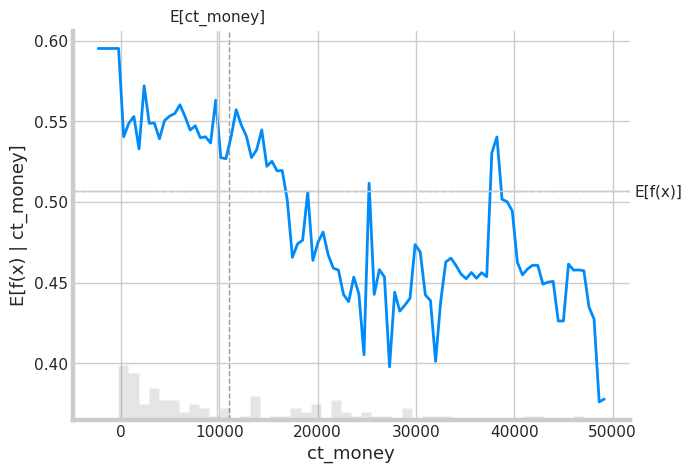

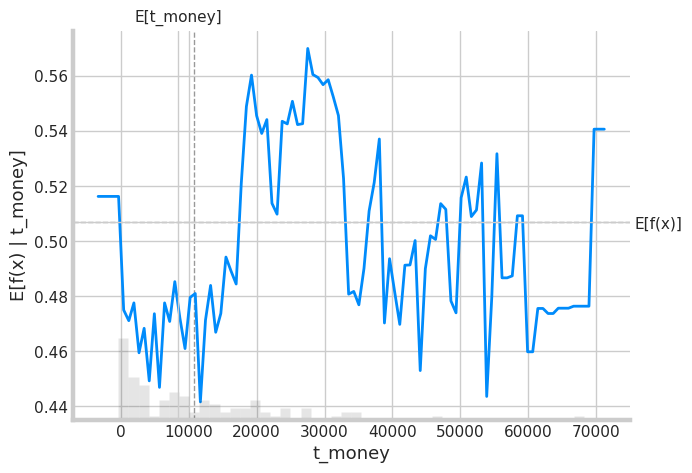

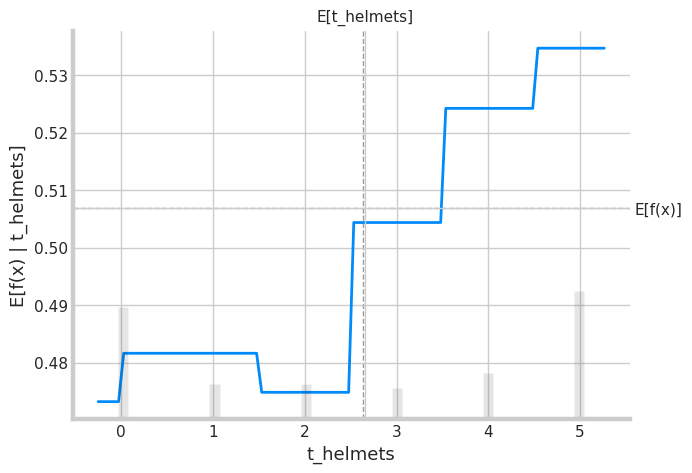

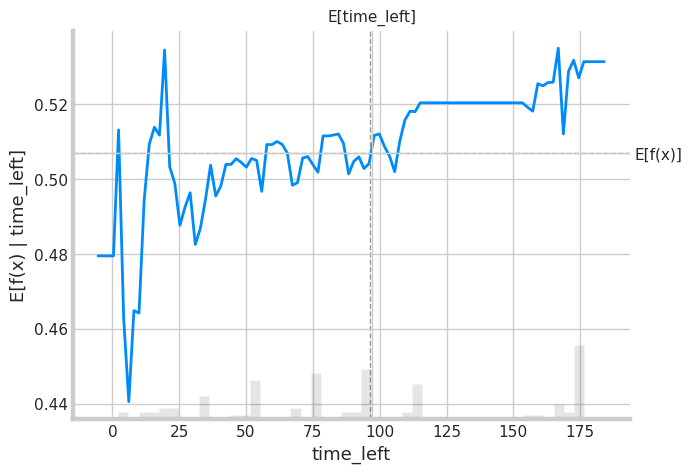

In [28]:
plot_num = 6
for f in top_features[:plot_num]:
    shap.partial_dependence_plot(
        f, model.predict, X100, ice=False,
        model_expected_value=True, feature_expected_value=True
    )

The gray horizontal line in the plot above represents the expected value of the model when applied to the California housing dataset. The vertical gray line represents the average value of the median income feature. Note that the blue partial dependence plot line (which the is average value of the model output when we fix the median income feature to a given value) always passes through the interesection of the two gray expected value lines. We can consider this intersection point as the “center” of the partial dependence plot with respect to the data distribution. The impact of this centering will become clear when we turn to Shapley values next.

In [14]:
# compute the SHAP values for the linear model
explainer100 = shap.Explainer(model.predict, X100)
shap_values100 = explainer100(X100)

# make a standard partial dependence plot
sample_ind = 26
shap.partial_dependence_plot(
    "ct_armor", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values100[sample_ind:sample_ind+1,:]
)

Permutation explainer:   5%|▌         | 5/100 [00:51<20:22, 12.87s/it]


KeyboardInterrupt: 

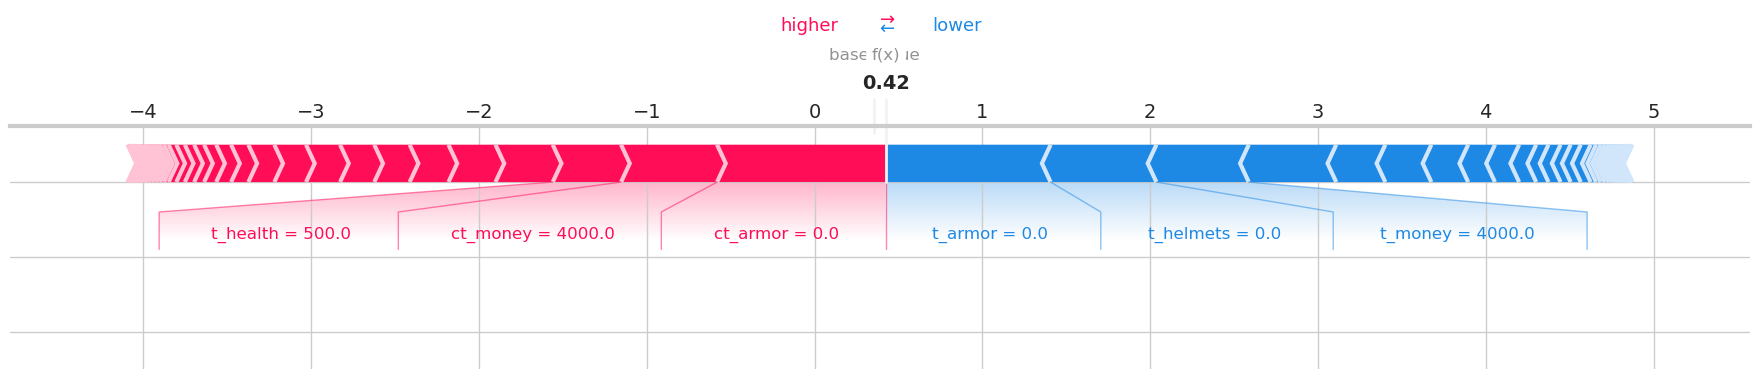

In [ ]:
# Plot on white background
shap.force_plot(explainer.expected_value[0], shap_values[1][0,:], X.iloc[0,:], matplotlib=True)
# test

In [ ]:
shap.force_plot(explainer100.expected_value[1], shap_values100[0][:1000,:], X.iloc[:1000,:])

AttributeError: 'Permutation' object has no attribute 'expected_value'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


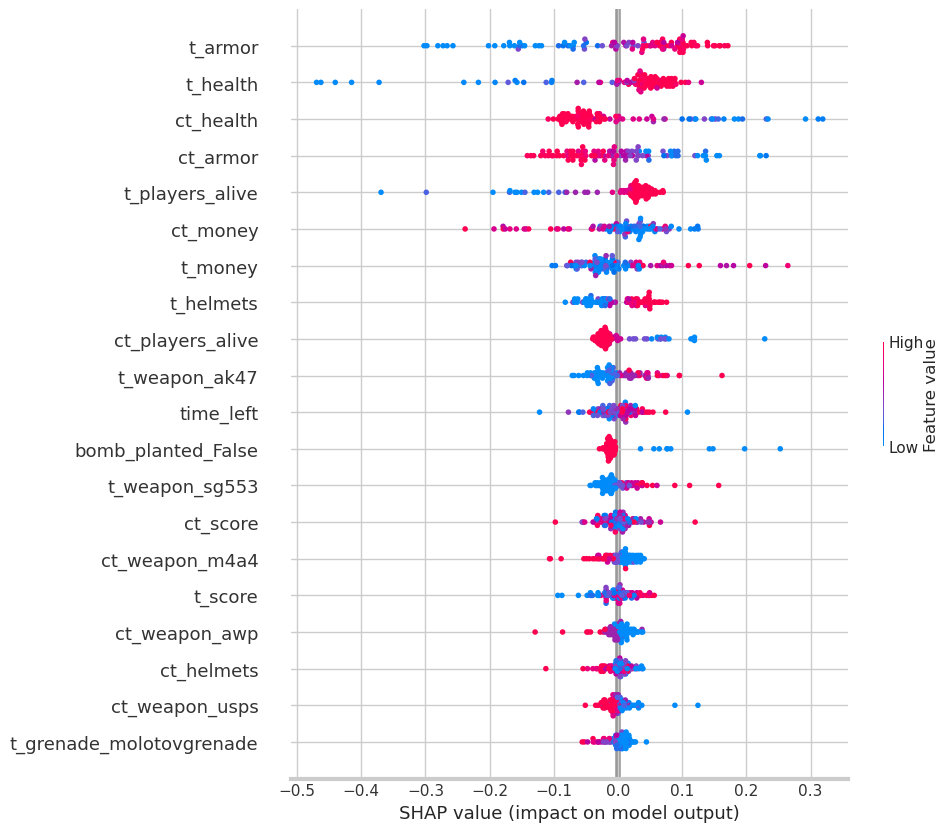

In [ ]:
shap.summary_plot(shap_values100, X100)

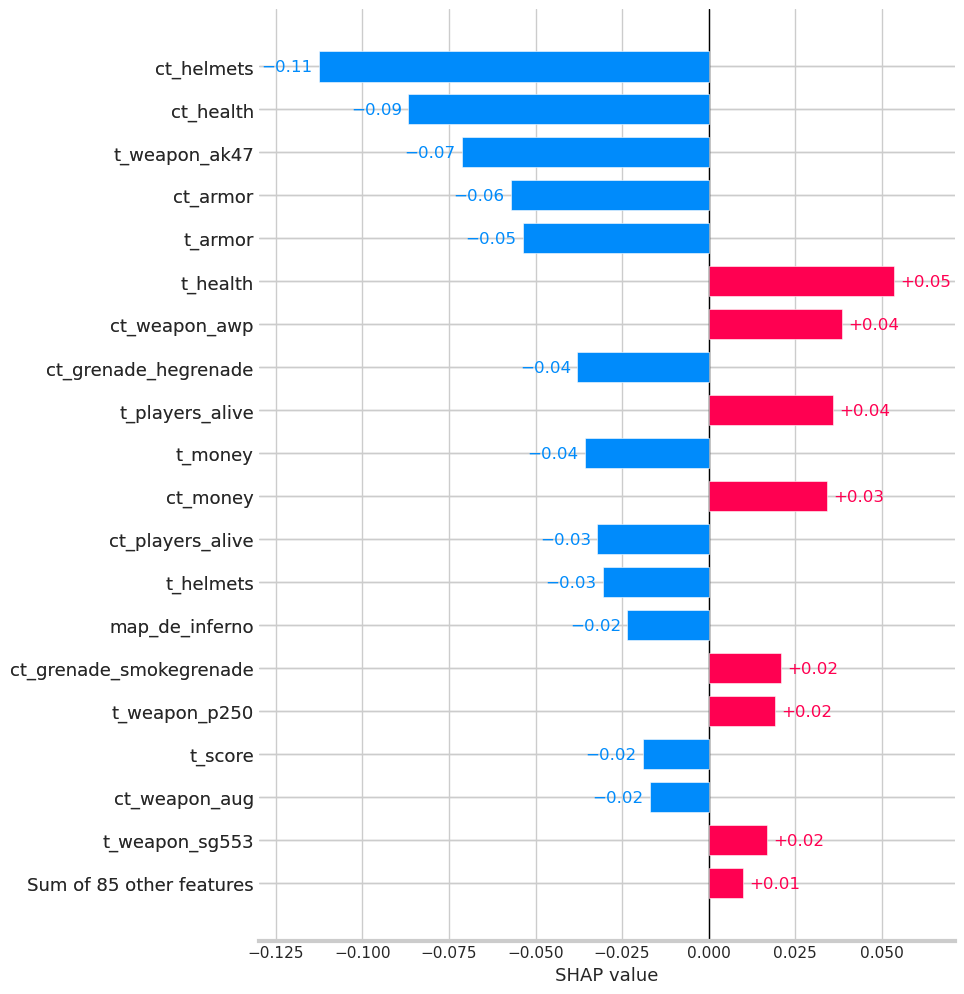

In [ ]:

# explainer = shap.Explainer(model, X_train, feature_dependence="interventional")
shap.plots.bar(shap_values100[0], max_display=20)
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0].values, df.values[0], feature, max_display=20)

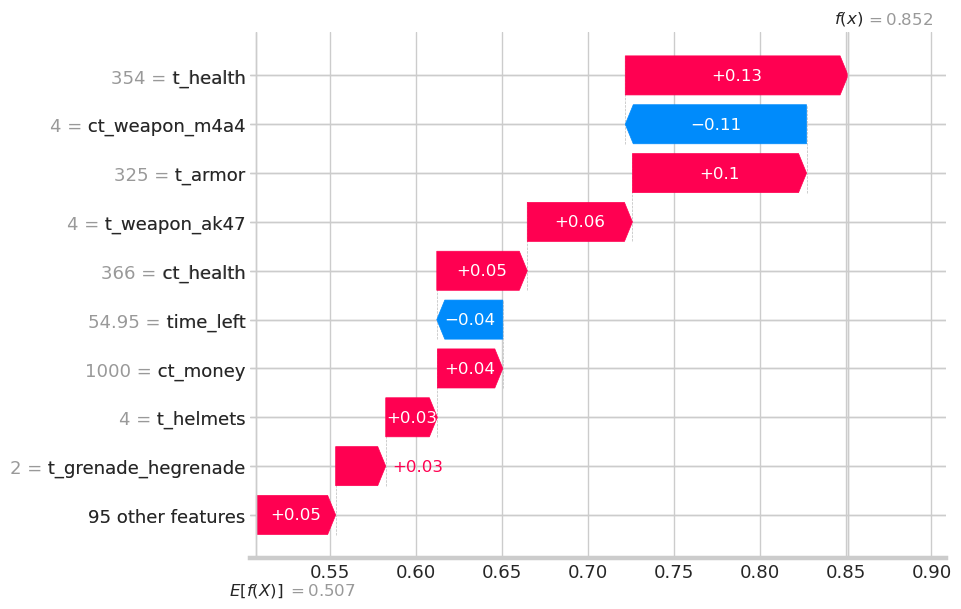

In [ ]:
# Create waterfall plot
shap.plots.waterfall(shap_values100[sample_ind])